<a href="https://colab.research.google.com/github/sumantn16/Bank_Loan_Modelling/blob/master/Bank_Loan_Modelling(Ensemble_Techniques).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
import xgboost as xgb

from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.utils import resample

from statsmodels.api import add_constant
import statsmodels.discrete.discrete_model as smt

import seaborn as sns

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [0]:
bank = pd.read_excel('/content/drive/My Drive/Colab Notebooks/Github/Bank_Personal_Loan_Modelling-1.xlsx',sheet_name='Data')

In [6]:
bank.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [7]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
ID                    5000 non-null int64
Age                   5000 non-null int64
Experience            5000 non-null int64
Income                5000 non-null int64
ZIP Code              5000 non-null int64
Family                5000 non-null int64
CCAvg                 5000 non-null float64
Education             5000 non-null int64
Mortgage              5000 non-null int64
Personal Loan         5000 non-null int64
Securities Account    5000 non-null int64
CD Account            5000 non-null int64
Online                5000 non-null int64
CreditCard            5000 non-null int64
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


In [8]:
bank.describe()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,2500.500000,45.338400,20.104600,73.774200,93152.503000,2.396400,1.937913,1.881000,56.498800,0.096000,0.104400,0.06040,0.596800,0.294000
std,1443.520003,11.463166,11.467954,46.033729,2121.852197,1.147663,1.747666,0.839869,101.713802,0.294621,0.305809,0.23825,0.490589,0.455637
min,1.000000,23.000000,-3.000000,8.000000,9307.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1250.750000,35.000000,10.000000,39.000000,91911.000000,1.000000,0.700000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,2500.500000,45.000000,20.000000,64.000000,93437.000000,2.000000,1.500000,2.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000
75%,3750.250000,55.000000,30.000000,98.000000,94608.000000,3.000000,2.500000,3.000000,101.000000,0.000000,0.000000,0.00000,1.000000,1.000000
max,5000.000000,67.000000,43.000000,224.000000,96651.000000,4.000000,10.000000,3.000000,635.000000,1.000000,1.000000,1.00000,1.000000,1.000000


# Exploratory Data Analysis

## Distribution of Data in each attributes

This represent the distribution of income in the dataset, it can be interpreted that most of the banks customers lies in the bracket of 30-80 thousand doller salary so we can say the dataset is about middle class family

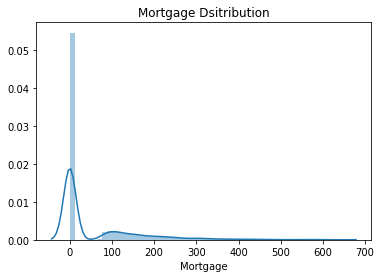

In [9]:
sns.distplot(bank.Mortgage, kde=True)
plt.title('Mortgage Dsitribution')
plt.show()

Most of the sample population doesn't have mortgage 

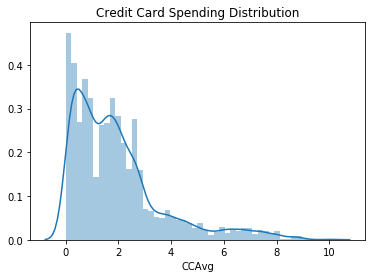

In [10]:
sns.distplot(bank.CCAvg, kde= True)
plt.title('Credit Card Spending Distribution')
plt.show()

The distribution of credit card expenditure is right skewed. Most of the population have less or no spending on credit cards

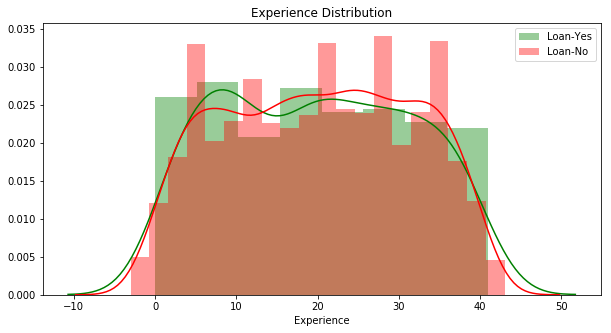

In [11]:
plt.figure(figsize=(10,5))
sns.distplot(bank.Experience[bank['Personal Loan']==1], kde=True, color='g',label='Loan-Yes')
sns.distplot(bank.Experience[bank['Personal Loan']==0], kde=True,color='r', label='Loan-No')
plt.title('Experience Distribution')
plt.legend()
plt.show()

As we can the see that experience is majorly distributed between 0 to 40 years and for people who have taken loan or not are also distributed throughout the range. There are few negative values which must be an error while filling the data. We will take care of that in feature engineering part of the project

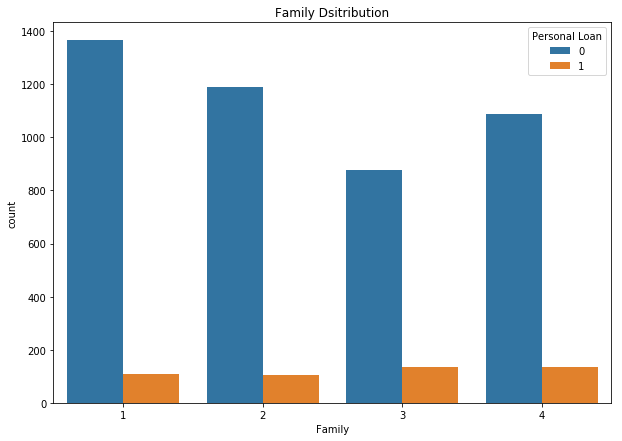

In [12]:
plt.figure(figsize=(10,7))
plt.title('Family Dsitribution')
sns.countplot(x='Family',hue='Personal Loan', data=bank)
plt.show()

In the family distribution, we can see that around 10% of the people from each class of families has taken a loan. The minimum is for person with 1 family member but not much difference between other family classes

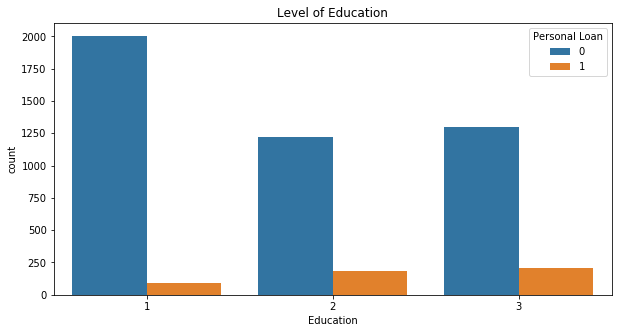

In [13]:
plt.figure(figsize=(10,5))
sns.countplot(x='Education', hue='Personal Loan',data=bank)
plt.title('Level of Education')
plt.show()

The level of education represents Undergrad,Graduate and Advanced/Professional, so we can interpret that people who are undergrad has low probability of taking the personal loan as compared to Graduate and Professionals

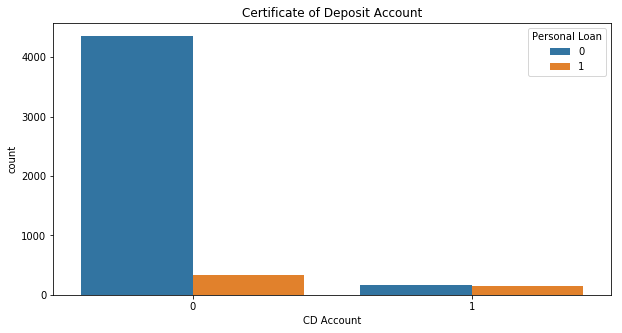

In [14]:
plt.figure(figsize=(10,5))
sns.countplot(x='CD Account', hue='Personal Loan',data=bank)
plt.title('Certificate of Deposit Account')
plt.show()

This plot represents that the people having the certificate of deposit account with the bank has high probability of taking personal loan than people with CD account. 

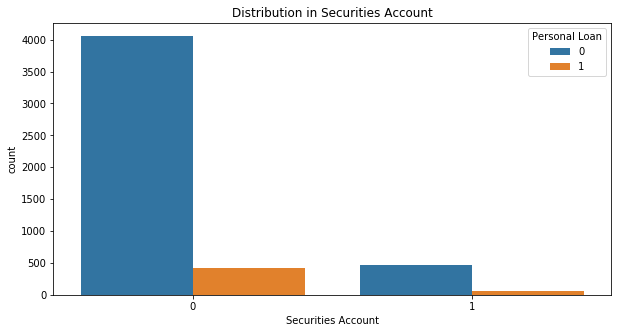

In [15]:
plt.figure(figsize=(10,5))
sns.countplot(x='Securities Account', hue='Personal Loan',data=bank)
plt.title('Distribution in Securities Account')
plt.show()

There are very few people with securities account in the sample but as in the barplot we can see that people who have securities account has comparatively high probability of taking the loan

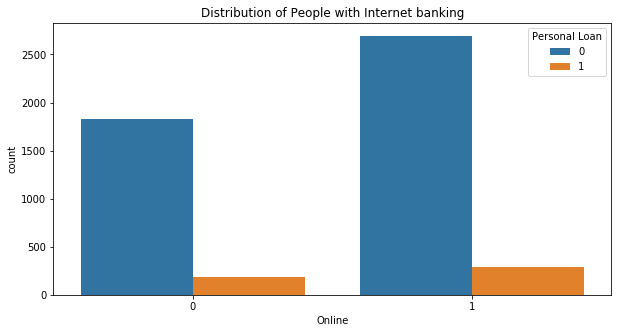

In [16]:
plt.figure(figsize=(10,5))
sns.countplot(x='Online', hue='Personal Loan',data=bank)
plt.title('Distribution of People with Internet banking')
plt.show()

There is a marginal difference between the people who have taken loan and internet banking and people who have taken loan without internet banking. 

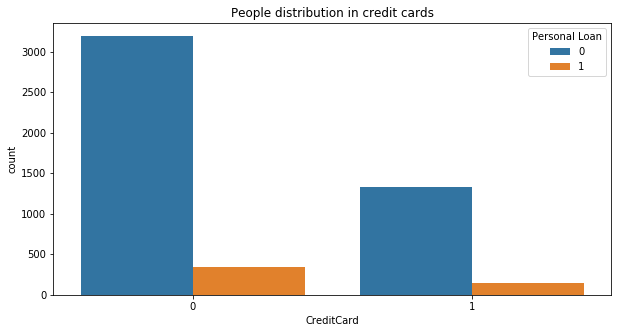

In [17]:
plt.figure(figsize=(10,5))
sns.countplot(x='CreditCard', hue='Personal Loan',data=bank)
plt.title('People distribution in credit cards')
plt.show()

This distribution of people with credit card & loan and without credit card & loan are not much different from each other. The conversion rate of liability customer in both the cases are almost similar

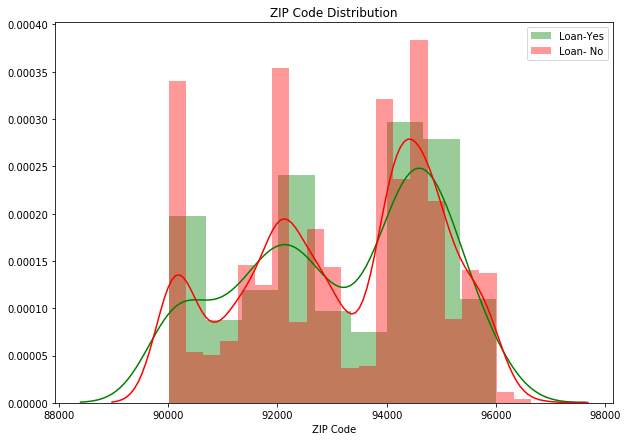

In [18]:
banktemp = bank[bank['ZIP Code'] > 80000] #There is a wrong value of code which has a digit missing, so we are removing it

plt.figure(figsize=(10,7))
sns.distplot(banktemp['ZIP Code'][banktemp['Personal Loan']==1], kde= True, color='g', label='Loan-Yes')
sns.distplot(banktemp['ZIP Code'][banktemp['Personal Loan']==0], kde= True, color='r', label='Loan- No')
plt.title('ZIP Code Distribution')
plt.legend()
plt.show()

As ZIP code is a categorical column and will not make any mathematical sense in the modelling and also the distribution of people taking loan is distributed across the zip codes so not much useful information here

## Bivariate Analysis

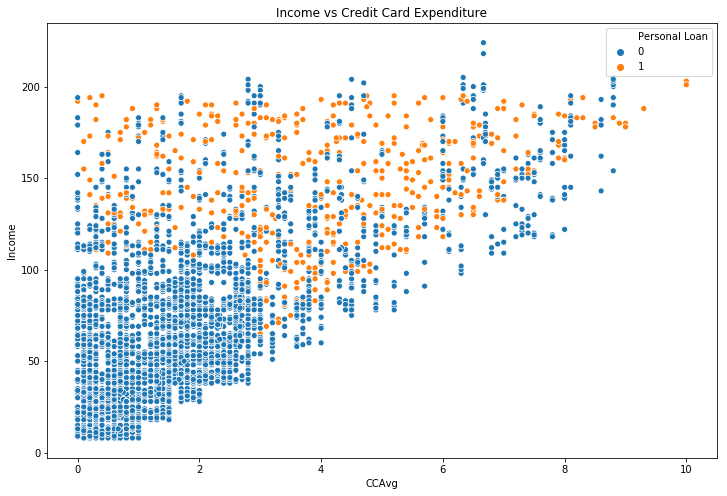

In [19]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='CCAvg', y='Income',hue='Personal Loan', data=bank)
plt.title('Income vs Credit Card Expenditure')
plt.show()

From the scatter plot between income and credit card expenditure, we can clearly see that people with low income have low credit card spending and have not taken a personal loan. But with higher income and expenditure the people who have taken loan and not are mixed in that population

## Target Column Analysis

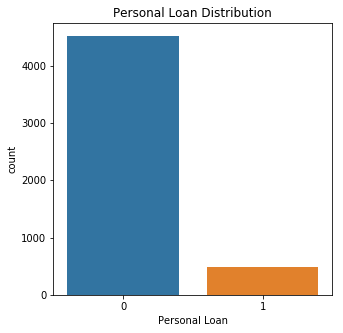

In [20]:
#The target column in the dataset is the classification table with binary value, where 0 represents that person has not taken
#the personal loan and 1 represents that person has taken the personal loan

plt.figure(figsize=(5,5))
sns.countplot(x='Personal Loan',data=bank)
plt.title('Personal Loan Distribution')
plt.show()

It is very obvious that the data is imbalance as we have only 480 rows of personal loan taken againse 5520 rows of loan not taken. In such cases the model tends to be biased towards the level having maximum values. To resolve this situation we can do over-sampling by using SMOTE to get the balanced dataset

In [21]:
#Using SMOTE to do the over-sampling

x= bank.drop('Personal Loan', axis=1)
y= bank['Personal Loan']
sm = SMOTE(k_neighbors=5,random_state=1)
x,y =sm.fit_sample(x,y)
x= pd.DataFrame(x, columns=['ID', 'Age', 'Experience', 'Income', 'ZIP Code', 'Family', 'CCAvg',
       'Education', 'Mortgage', 'Securities Account',
       'CD Account', 'Online', 'CreditCard'])
y=pd.DataFrame(y, columns=['Personal Loan'])

bankos = pd.concat([x,y],axis=1)
bankos.shape

(9040, 14)

In [22]:
#Now the data for personal loan will become unbiased

bankos.groupby('Personal Loan').count()['ID']

Personal Loan
0    4520
1    4520
Name: ID, dtype: int64

Both 0 and 1 contains equal number of values which will help us in building better unbiased model

# Feature Engineering

In [0]:
#There are 52 columns in experience with negative values, as experience cannot be negative we can assume that it was a input 
#error and we are are converting those in the positive values for prediction

bankos.Experience = np.abs(bankos.Experience)

In [0]:
#Zip code is a categorical variable and has not any numerical sense and as per our observation there are 467 unique zip codes.
#So we will drop the column insteat of using it in the model

bankos.drop('ZIP Code',axis=1,inplace=True)

In [0]:
#ID is the primary key column so we will not use it for modelling

bankos.drop('ID',axis=1,inplace=True)

In [0]:
#Seperate independent and dependent variables

x= bankos.drop(['Personal Loan','Age','Mortgage','Experience'],axis=1) #we will drop columns with the help of logit regression results
y= bankos['Personal Loan']

sc = StandardScaler()
x_std = sc.fit_transform(x)

In [0]:
#we split the data into test and train

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=2)
x_train_std = sc.fit_transform(x_train)
x_test_std = sc.transform(x_test)

In [28]:
#Logit Regeression Result
#We will drop columns using p-value in the summary to generate better accuracy

x2= add_constant(x) 
logit= smt.Logit(y,x2)
result=logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.216868
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:          Personal Loan   No. Observations:                 9040
Model:                          Logit   Df Residuals:                     9031
Method:                           MLE   Df Model:                            8
Date:                Mon, 02 Sep 2019   Pseudo R-squ.:                  0.6871
Time:                        07:31:54   Log-Likelihood:                -1960.5
converged:                       True   LL-Null:                       -6266.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -11.9223      0.314    -38.027      0.000     -12.537     -11.308
Incom

# Modeling

The above analysis has helped us in reducing the number of attributes based on p-value, now we will built classification models using
1. Logistic Regression
2. KNN Classifier
3. Decision Tree
4. Gaussian Naive Bayes

## 1. Logistic Regression

In [29]:
logreg = LogisticRegression()
logreg.fit(x_train,y_train)
print('The accuracy score for Logistic Regression model is %1.2f per cent' %((logreg.score(x_test,y_test))*100))

The accuracy score for Logistic Regression model is 91.41 per cent


## 2. KNN Classifier

In [30]:
#For knn model we will first find out the best number of neighbors to be selected using grid search algorithm

knncl = KNeighborsClassifier()
param= {'n_neighbors': range(1,30)}
knngrid = GridSearchCV(knncl, param_grid= param, cv=5)
knngrid.fit(x_std,y) #for distance based model we use standardize values
knngrid.best_params_

{'n_neighbors': 1}

In [31]:
knncl = KNeighborsClassifier(n_neighbors=1)
knncl.fit(x_train_std,y_train)
print('The accuracy score for KNN Classifier model is %1.2f per cent' %((knncl.score(x_test_std,y_test))*100))

The accuracy score for KNN Classifier model is 99.00 per cent


## 3. Decision Tree

In [32]:
#Foe decision tree we will again do the grid search for max depth, otherwise model will become over-fit

dtcl = DecisionTreeClassifier()
params= {'max_depth': np.arange(1,30)}
dtgrid= GridSearchCV(dtcl,params,cv=5)
dtgrid.fit(x,y)
dtgrid.best_params_

{'max_depth': 13}

In [33]:
dtcl = DecisionTreeClassifier(max_depth=14)
dtcl.fit(x_train, y_train)
print('The accuracy score for Decision Tree model is %1.2f per cent' %((dtcl.score(x_test,y_test)*100)))

The accuracy score for Decision Tree model is 98.78 per cent


## 4. Gaussian Naive Bayes

In [34]:
gnbcl = GaussianNB()
gnbcl.fit(x_train, y_train)
print('The accuracy score for Gaussian Naive Bayes model is %1.2f per cent' %((gnbcl.score(x_test,y_test)*100)))

The accuracy score for Gaussian Naive Bayes model is 89.12 per cent


## Model Comparision

### K-Fold Cross Validation

In [0]:
#We will perform this validation to check which model is workling consistently better among these four

models=[]
models.append(('Logistic Regression', logreg))
models.append(('Naive Bayes', gnbcl))
models.append(('KNeighbour',knncl))
models.append(('Decision Tree',dtcl))

In [36]:
results= []
names= []

for name,model in models:
    kfold= model_selection.KFold(n_splits = 10, random_state=2, shuffle=True)
    cv_results = model_selection.cross_val_score(model, x, y, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" %(name,cv_results.mean(),cv_results.std())
    print(msg)

Logistic Regression: 0.916704 (0.008115)
Naive Bayes: 0.890819 (0.007136)
KNeighbour: 0.963606 (0.003514)
Decision Tree: 0.987942 (0.002344)


As we can see from the k-fold cross validation we are getting the best result in Decision tree which is 98% accuracy and 0.1% standard deviation. So we will choose Decision Tree model over other classification models. Now we will check the confidence interval for Decision Tree model

# Ensemble Techniques

In ensemble techiques, we will make use following classification models:
1. Random Forest Classifier
2. Bagging Classifier
3. Ada Boost Classifier
4. Gradient Boost Classifier
5. Voting Classifier
6. XG Boosting Classifier

## 1. Random Forest Classifier

In [38]:
rfcl = RandomForestClassifier()
param = {'n_estimators': sp_randint(1, 80)}
randomCV = RandomizedSearchCV(rfcl, param_distributions=param, n_iter=80)
randomCV.fit(x,y)
randomCV.best_params_

{'n_estimators': 27}

In [39]:
rfcl = RandomForestClassifier(n_estimators=9)
rfcl.fit(x_train, y_train)
rfcl.score(x_test,y_test)

0.9907817109144543

## 2. Bagging Classifier

In [40]:
bgcl = BaggingClassifier()
param = {'n_estimators': sp_randint(1, 80)}
randomCV = RandomizedSearchCV(bgcl, param_distributions=param, n_iter=80)
randomCV.fit(x,y)
randomCV.best_params_

{'n_estimators': 74}

In [41]:
bgcl = BaggingClassifier(n_estimators=76)
bgcl.fit(x_train, y_train)
bgcl.score(x_test,y_test)

0.9933628318584071

## 3. Ada Boost Classifier

In [42]:
abcl = AdaBoostClassifier()
param = {'n_estimators': sp_randint(1, 80)}
randomCV = RandomizedSearchCV(abcl, param_distributions=param, n_iter=80)
randomCV.fit(x,y)
randomCV.best_params_

{'n_estimators': 71}

In [43]:
abcl = AdaBoostClassifier(n_estimators=71)
abcl.fit(x_train, y_train)
abcl.score(x_test,y_test)

0.9775073746312685

## 4. Gradient Boost Classifier

In [44]:
gbcl = GradientBoostingClassifier()
param = {'n_estimators': sp_randint(1, 80)}
randomCV = RandomizedSearchCV(gbcl, param_distributions=param, n_iter=80)
randomCV.fit(x,y)
randomCV.best_params_

{'n_estimators': 76}

In [45]:
gbcl = GradientBoostingClassifier(n_estimators = 78)
gbcl.fit(x_train,y_train)
gbcl.score(x_test,y_test)

0.9911504424778761

## 5. Voting Classifier

In [0]:
logreg = LogisticRegression()
knncl = KNeighborsClassifier(n_neighbors=1)
dtcl = DecisionTreeClassifier(max_depth=14)
gnbcl = GaussianNB()

vocl = VotingClassifier(estimators = [('log', logreg), ('KNN', knncl), ('Gaussian', gnbcl), ('DecisionTree', dtcl)], voting = 'hard')

In [47]:
vocl.fit(x_train,y_train)
vocl.score(x_test,y_test)

0.9572271386430679

## 6. XG Boost Classifier

In [48]:
xgcl = xgb.XGBClassifier()
param = {'n_estimators': sp_randint(1, 80)}
randomCV = RandomizedSearchCV(xgcl, param_distributions=param, n_iter=80)
randomCV.fit(x,y)
randomCV.best_params_

{'n_estimators': 79}

In [49]:
xgcl = xgb.XGBClassifier(n_estimators=79)
xgcl.fit(x_train, y_train)
xgcl.score(x_test,y_test)

0.9893067846607669

## Ensemble Model Comparision

### K-Fold Analysis

In [0]:
#We will perform this validation to check which model is workling consistently better among these four

models=[]
models.append(('Random Forest Classifier', rfcl))
models.append(('Bagging Classifier', bgcl))
models.append(('Ada Boosting Classifier',abcl))
models.append(('Gradient Boosting Classifier',gbcl))
models.append(('Voting Classifier',vocl))
models.append(('XG Boost Classifier',xgcl))

In [51]:
results= []
names= []

for name,model in models:
    kfold= model_selection.KFold(n_splits = 10, random_state=2, shuffle=True)
    cv_results = model_selection.cross_val_score(model, x, y, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" %(name,cv_results.mean(),cv_results.std())
    print(msg)

Random Forest Classifier: 0.991261 (0.002592)
Bagging Classifier: 0.991482 (0.003052)
Ada Boosting Classifier: 0.974668 (0.003408)
Gradient Boosting Classifier: 0.989602 (0.002483)
Voting Classifier: 0.958739 (0.004535)
XG Boost Classifier: 0.989270 (0.002844)


It is evident that the Random Forest Classifier is giving the better result among all six ensemble techniques. The accuracy is highest and standard deviation is lowest for Random Forest. So we will choose this ensemble technique to get best result on the given dataset of bank.